# Poem: Logistic Regression

For this project, the text is the feature and the label is the date of the poem.

We use logistic regression for a multi-class text classification task.

With no preprocessing, the model has 304 targets. We will present the results of different models depending on the preprocessing.

In [ ]:
# If you do not have stopwords
import nltk
nltk.download("stopwords")


# 🎓 Library

In [21]:
# Misc
import os
import numpy as np
import pandas as pd
import pickle
import re

# Training
from nltk.corpus import stopwords

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

DATA = "../data/"
RANDOM_STATE = 42

if not os.path.exists(DATA):
    raise FileNotFoundError(f"Data directory {DATA} does not exist. Please create it and add the data files.")

In [22]:
poems_df = pd.read_parquet(DATA + "de_poems.parquet")

In [23]:
poems_df.head(3)["text"].values

array(['Gebohrn, und wiederumb, o Mensch, gebohren werden,\nErrettet dich vom Tod und hilfft dir in Beschwerden.',
       'Es suchte niemand Gott, liegt er gleich unterm Leben,\nWär er nicht Lieb und hätt es nicht mit Lieb umbgeben.',
       'Die ist in Gott, und Gott der ist zugleich in Ihr,\nIn der ich leb, und die auch wieder lebt in mir.'],
      dtype=object)

# Preprocessing

In [24]:
import sys
sys.path.append("../")
from env import get_period

poems = poems_df.copy()

# Transform all date to centuries, else we have 304 classes
poems["creation"] = poems["creation"].astype(int)

# For model A
poems["century"] = poems["creation"].apply(lambda x: str(x // 100 + 1))

# For model B
poems["movement"] = poems["creation"].apply(get_period)

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    return ' '.join(tokens)

poems["cleaned_text"] = poems["text"].apply(preprocess)

In [25]:
poems.head(3)[["text", "cleaned_text"]]


,text,cleaned_text
0,"Gebohrn, und wiederumb, o Mensch, gebohren wer...",gebohrn und wiederumb o mensch gebohren werden...
1,"Es suchte niemand Gott, liegt er gleich unterm...",es suchte niemand gott liegt er gleich unterm ...
2,"Die ist in Gott, und Gott der ist zugleich in ...",die ist in gott und gott der ist zugleich in i...


## Model creation and tuning

When calling the `fit` method of the model, the y parameter will be different (either century or movement).

We use SMOTE in order to create synthetic samples for the minority class (11th century).

This reduces accuracy, but increases F1 score.

In [26]:
# Remove german stop words
german_stop_words = stopwords.words("german")

# Pipeline to fine-tune encoding and model
# No need to fit_transform, pipeline will do it
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=german_stop_words, ngram_range=(1, 2), max_df = 0.9, max_features=10000)),
    # To keep the interesting features
    ("SMOTE", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(random_state = RANDOM_STATE, solver = "lbfgs", penalty = "l2", max_iter = 100, verbose = 10, class_weight=None))
])

x = poems["cleaned_text"]
# y will be defined depending on the model

In [27]:
# For now best config is : penalty = "L2", solver = "lbfgs", max_iter = 100

# https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust

# Hyperparameter grid
param_grid = [
    {
    #    "tfidf__max_df": [0.9, 1.0],
    #    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    #    "tfidf__max_features": [None, 10000, 20000],
    #    "clf__class_weight": [None, "balanced"],
    #    "clf__solver": ["lbfgs", "saga"],
    #    "cfl__penalty": ["l1", "l2"],
    #    "clf__max_iter": [100, 350]
    }
]

clf = GridSearchCV(pipeline, param_grid, n_jobs = 4, cv = 2, verbose = True)


# Model A: SMOTE, Per Century

Each poem is mapped to a century.

Our feature is `text`, and the label is `century`.

## Step 1: Feature selection

In [28]:
y = poems["century"]

In [29]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} dates.")

Currently have 71570 poems with 8 dates.


## Step 2: Data splitting and model training

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [31]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((57256,), (14314,), (57256,), (14314,))

In [32]:
clf.fit(x_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/tofeha/miniconda3/envs/NLP1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   24.0s
/home/tofeha/miniconda3/envs/NLP1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=10000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['aber',
                                                                    'alle',
                                                                    'allem',
                                                                    'allen',
                                                                    'aller',
                                                                    'alles',
                                                                    'als',
                                                                    'also',
                                                                    'am', 'an',
                                                                    'ander',
                                                                    'andere',
                                                                    'anderem',
                                                                    'anderen',
                                                                    'anderer',
                                                                    'anderes',
                                                                    'anderm',
                                                                    'andern',
                                                                    'anderr',
                                                                    'anders',
                                                                    'auch',
                                                                    'auf',
                                                                    'aus',
                                                                    'bei',
                                                                    'bin',
                                                                    'bis',
                                                                    'bist',
                                                                    'da',
                                                                    'damit',
                                                                    'dann', ...])),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           verbose=10))]),
             n_jobs=4, param_grid=[{}], verbose=True)

In [33]:
century_model = clf.best_estimator_
century_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=10000,
                                 ngram_range=(1, 2),
                                 stop_words=['aber', 'alle', 'allem', 'allen',
                                             'aller', 'alles', 'als', 'also',
                                             'am', 'an', 'ander', 'andere',
                                             'anderem', 'anderen', 'anderer',
                                             'anderes', 'anderm', 'andern',
                                             'anderr', 'anders', 'auch', 'auf',
                                             'aus', 'bei', 'bin', 'bis', 'bist',
                                             'da', 'damit', 'dann', ...])),
                ('SMOTE', SMOTE(random_state=42)),
                ('clf', LogisticRegression(random_state=42, verbose=10))])

In [34]:
century_model.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.9, max_features=10000, ngram_range=(1, 2),
                   stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                               'als', 'also', 'am', 'an', 'ander', 'andere',
                               'anderem', 'anderen', 'anderer', 'anderes',
                               'anderm', 'andern', 'anderr', 'anders', 'auch',
                               'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da',
                               'damit', 'dann', ...])),
  ('SMOTE', SMOTE(random_state=42)),
  ('clf', LogisticRegression(random_state=42, verbose=10))],
 'transform_input': None,
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=10000, ngram_range=(1, 2),
                 stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                             'als', 'also', 'am', 'an', 'ander', 'andere',
                             'anderem', 'anderen', 'anderer', 'a

#### Quick save

In [40]:
pickle.dump(century_model, open("../trained/LR_Century_model_SMOTE.pkl", "wb"))

## Step 3: Evaluation and finetuning

In [35]:
y_pred = century_model.predict(x_test)

In [36]:
print(classification_report(y_test,y_pred, zero_division=0))

              precision    recall  f1-score   support

          11       0.34      0.58      0.43        55
          13       0.73      0.44      0.55        18
          14       0.75      0.79      0.77       189
          16       0.95      0.84      0.89       210
          17       0.91      0.90      0.90      4032
          18       0.71      0.74      0.72      2880
          19       0.87      0.78      0.82      6476
          20       0.32      0.71      0.44       454

    accuracy                           0.80     14314
   macro avg       0.70      0.72      0.69     14314
weighted avg       0.83      0.80      0.81     14314



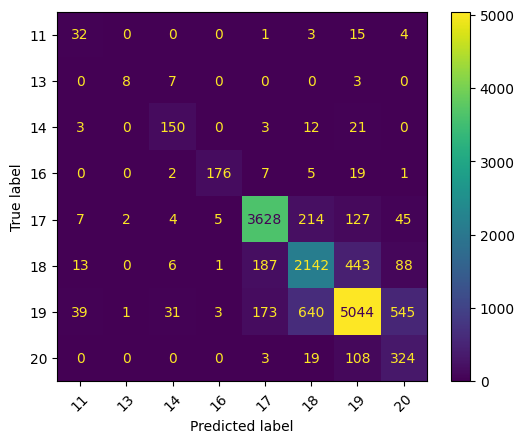

In [37]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=century_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

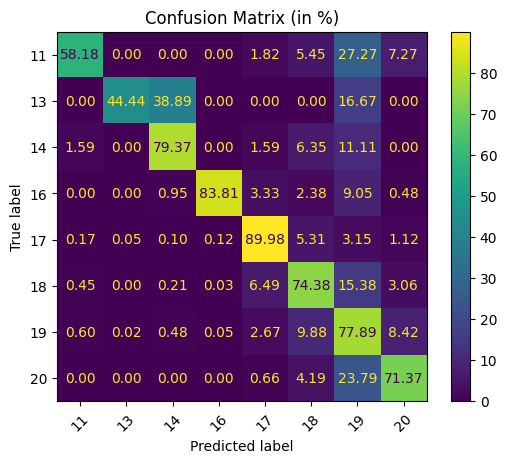

In [38]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=century_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [39]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


# Model C: SMOTE, Per Movement

Each poem is mapped to a German literary movement.

Our feature is `text`, and the label is `movement`.

## Step 1: Feature selection

In [ ]:
y = poems["movement"]

In [ ]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} movements.")

## Step 2: Data splitting and model training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
movement_model = clf.best_estimator_
movement_model

In [ ]:
movement_model.get_params()

#### Quick save

In [ ]:
pickle.dump(movement_model, open("../trained/LR_Movement_model.pkl", "wb"))

## Step 3: Evaluation and finetuning

In [ ]:
y_pred = movement_model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred, zero_division=0))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=movement_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")